# ROC and PR curve examples

## Setup

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sys.path.append("..")
import src

primary, accent = src.theme.set()
pal = sns.color_palette("wfondrie")

half_size = (4.5, 4)

def save(fname):
    """Save the figures"""
    figures = Path("figures")
    figures.mkdir(exist_ok=True)
    if not fname.startswith("04_"):
        fname = "04_" + fname
        
    if not fname.endswith(".png"):
        fname += ".png"
    
    plt.tight_layout(pad=0.2)
    plt.savefig(figures / fname, dpi=300)

## Create the examples we'll be using:

In [2]:
# Set the random seed for reproducibility:
rng = np.random.default_rng(42)

n_examples = 20
df = pd.DataFrame({
    "label": [True]*n_examples + [False]*n_examples,
    "disease": ["Case"]*n_examples + ["Control"]*n_examples,
    "score_1": np.concatenate(
        [rng.normal(3.5, 1, size=n_examples), rng.normal(2, 1, size=n_examples)]
    ),
    "score_2": np.concatenate(
        [rng.normal(4, 1, size=n_examples), rng.normal(2, 1, size=n_examples)]
    )
})

fpr_1, tpr_1, _ = metrics.roc_curve(df["label"], df["score_1"])
prc_1, rec_1, _ = metrics.precision_recall_curve(df["label"], df["score_1"])
fpr_2, tpr_2, _ = metrics.roc_curve(df["label"], df["score_2"])
prc_2, rec_2, _ = metrics.precision_recall_curve(df["label"], df["score_2"])

print("score_1 ROC AUC:", metrics.roc_auc_score(df["label"], df["score_1"]))
print("score_2 ROC AUC:", metrics.roc_auc_score(df["label"], df["score_2"]))
print("score_1 AP:", metrics.average_precision_score(df["label"], df["score_1"]))
print("score_2 AP:", metrics.average_precision_score(df["label"], df["score_2"]))

score_1 ROC AUC: 0.8699999999999999
score_2 ROC AUC: 0.9849999999999999
score_1 AP: 0.8789247886616309
score_2 AP: 0.9884615384615385


Make a plot describing the data

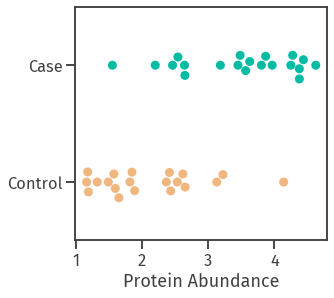

In [3]:
fig, ax = plt.subplots(figsize=half_size)
sns.swarmplot(x=df["score_1"], y=df["disease"], size=9, ax=ax)
ax.set_xlabel("Protein Abundance")
ax.set_ylabel("")
save("swarm")

## Plot ROC curves

First we'll create a plotting function to create well formatted axes:

In [4]:
def roc_axis(ax=None):
    """Create a matplotlib axis that is labeled and scaled for ROC curves"""
    if ax is None:
        ax = plt.gca()
        
    ax.plot([0, 1], [0, 1], color=primary, linestyle="dashed", zorder=0)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("1 - Specificity (FPR)")
    ax.set_ylabel("Sensitivity (TPR)")
    return ax

def pr_axis(pos_frac, ax=None):
    """Create a matplotlib axis that is labeled and scaled for ROC curves"""
    if ax is None:
        ax = plt.gca()
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.axhline(pos_frac, color=primary, linestyle="dashed", zorder=1)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("Recall (TPR)")
    ax.set_ylabel("Precision (PPV)")
    return ax

### Build up an ROC curve manually

/var/folders/8x/xhjqq1ss58jcyc89wf32hc0c0000gn/T/ipykernel_85468/1967137864.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=half_size)


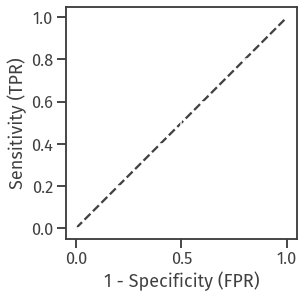

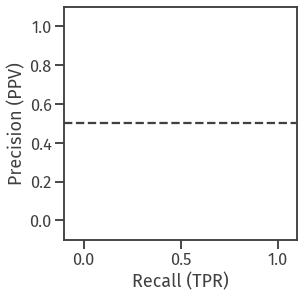

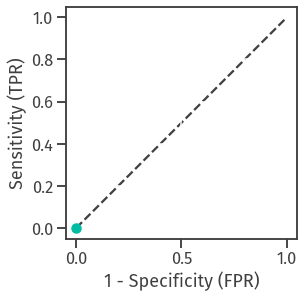

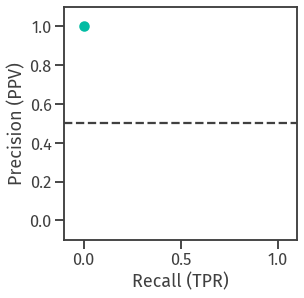

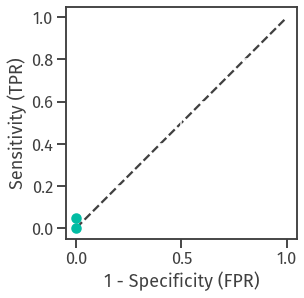

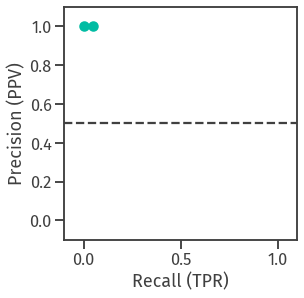

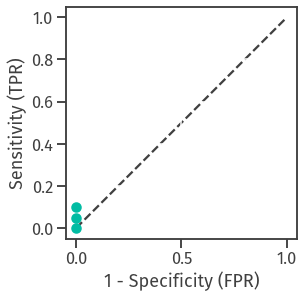

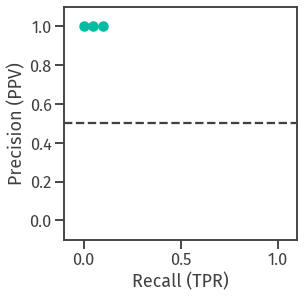

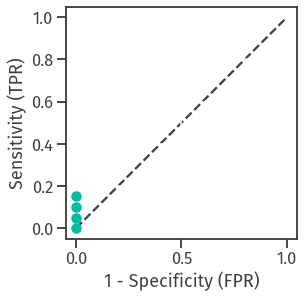

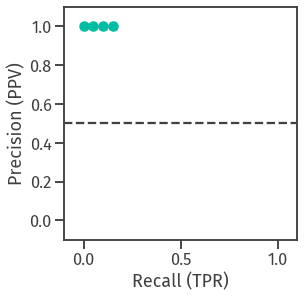

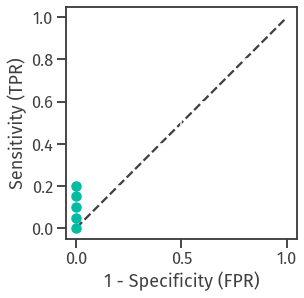

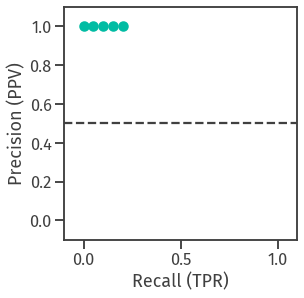

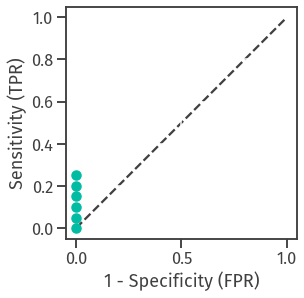

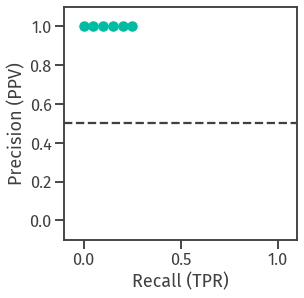

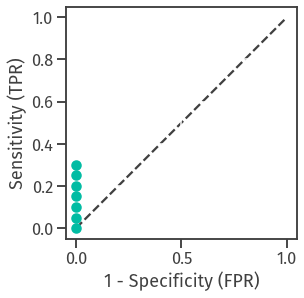

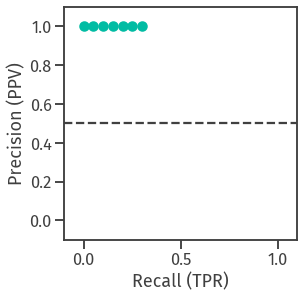

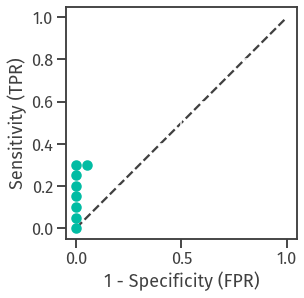

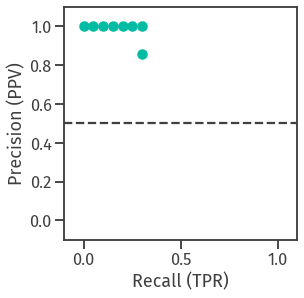

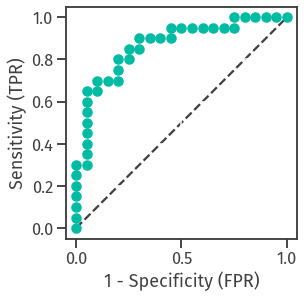

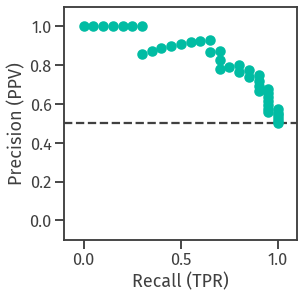

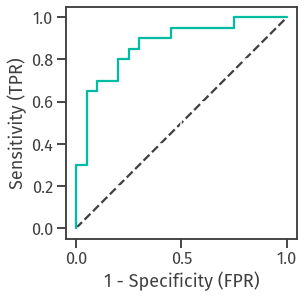

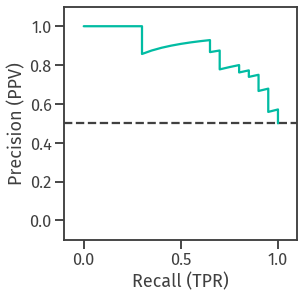

In [5]:
df = df.sort_values("score_1", ascending=False)
df["one"] = 1
df["tpr"] = df["label"].cumsum() / df["label"].sum()
df["fpr"] = (~df["label"]).cumsum() / (~df["label"]).sum()
df["prc"] = df["label"].cumsum() / df["one"].cumsum()
df["rec"] = df["label"].cumsum() / df["label"].sum()

pos_frac = df["label"].sum() / len(df)

# Plot the build-up:
fig, ax = plt.subplots(figsize=half_size)
ax = roc_axis(ax)
save("roc_buildup_blank.png")

fig, ax = plt.subplots(figsize=half_size)
ax = pr_axis(pos_frac, ax)
save("pr_buildup_blank.png")

for idx in range(8):
    fig, ax = plt.subplots(figsize=half_size)
    ax = roc_axis(ax)
    sel = df.iloc[:idx, :]
    ax.scatter([0] + list(sel["fpr"]), [0] + list(sel["tpr"]))
    save(f"roc_buildup_{idx}")
    
    fig, ax = plt.subplots(figsize=half_size)
    ax = pr_axis(pos_frac, ax)
    ax.scatter([0] + list(sel["rec"]), [1] + list(sel["prc"]))
    save(f"pr_buildup_{idx}")
    
# Final scatter plot:
fig, ax = plt.subplots(figsize=half_size)
ax = roc_axis(ax)
ax.scatter([0] + list(df["fpr"]), [0] + list(df["tpr"]))
save("roc_buildup_scatter")

fig, ax = plt.subplots(figsize=half_size)
ax = pr_axis(pos_frac, ax)
ax.scatter([0] + list(df["rec"]), [1] + list(df["prc"]))
save("pr_buildup_scatter")

# Remove the points
fig, ax = plt.subplots(figsize=half_size)
ax = roc_axis(ax)
ax.plot([0] + list(df["fpr"]), [0] + list(df["tpr"]))
save("roc_score_1")

fig, ax = plt.subplots(figsize=half_size)
ax = pr_axis(pos_frac, ax)
ax.plot([0] + list(df["rec"]), [1] + list(df["prc"]))
save("pr_score_1")

## Plot various versions of ROC curves

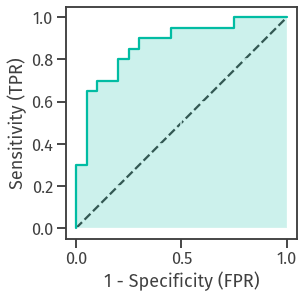

In [6]:
fig, ax = plt.subplots(figsize=half_size)
ax = roc_axis(ax)
ax.plot(fpr_1, tpr_1)
ax.fill_between(fpr_1, tpr_1, facecolor=pal[0], alpha=0.2)
save("roc_filled")

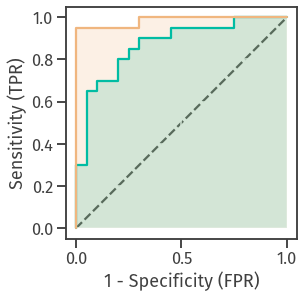

In [7]:
fig, ax = plt.subplots(figsize=half_size)
ax = roc_axis(ax)
ax.plot(fpr_1, tpr_1)
ax.plot(fpr_2, tpr_2)
ax.fill_between(fpr_1, tpr_1, facecolor=pal[0], alpha=0.2)
ax.fill_between(fpr_2, tpr_2, facecolor=pal[1], alpha=0.2)
save("roc_both_scores.png")

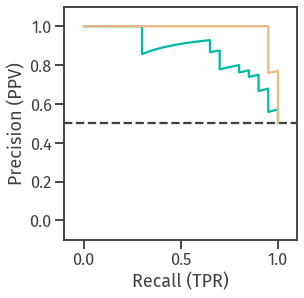

In [8]:
fig, ax = plt.subplots(figsize=half_size)
ax = pr_axis(pos_frac, ax)
ax.plot([1] + list(rec_1), [pos_frac] + list(prc_1))
ax.plot([1] + list(rec_2), [pos_frac] + list(prc_2))
save("pr-curves-2")

## Create an imbalanced dataset

In [26]:
# Set the random seed for reproducibility:
rng = np.random.default_rng(1)

n_examples = (5, 95)
df = pd.DataFrame({
    "label": [True]*n_examples[0] + [False]*n_examples[1],
    "disease": ["Case"]*n_examples[0] + ["Control"]*n_examples[1],
    "score_1": np.concatenate(
        [
            rng.normal(5, 1, size=n_examples[0]), 
            rng.normal(3, 2, size=n_examples[1]),
        ]
    ),
    "score_2": np.concatenate(
        [
            rng.normal(5, 1, size=n_examples[0]), 
            rng.normal(3, 1, size=n_examples[1]),
        ]
    ),
})

fpr_1, tpr_1, _ = metrics.roc_curve(df["label"], df["score_1"])
fpr_2, tpr_2, _ = metrics.roc_curve(df["label"], df["score_2"])
prc_1, rec_1, _ = metrics.precision_recall_curve(df["label"], df["score_1"])
prc_2, rec_2, _ = metrics.precision_recall_curve(df["label"], df["score_2"])
print("score_1 AUC:", metrics.roc_auc_score(df["label"], df["score_1"]))
print("score_2 AUC:", metrics.roc_auc_score(df["label"], df["score_2"]))
print("score_1 AP:", metrics.average_precision_score(df["label"], df["score_1"]))
print("score_2 AP:", metrics.average_precision_score(df["label"], df["score_2"]))

df = df.sort_values("score_1", ascending=False).reset_index()
df["tpr"] = df["label"].cumsum() / df["label"].sum()
df["fdr"] = (~df["label"]).cumsum() / (df.index+1)
df.head(20)

score_1 AUC: 0.9178947368421053
score_2 AUC: 0.9747368421052631
score_1 AP: 0.3836309523809524
score_2 AP: 0.680952380952381


,index,label,disease,score_1,score_2,tpr,fdr
0,30,False,Control,7.235678,2.651883,0.0,1.000000
1,33,False,Control,7.085543,3.277883,0.0,1.000000
2,4,True,Case,5.905356,6.218844,0.2,0.666667
3,1,True,Case,5.821618,5.862445,0.4,0.500000
4,22,False,Control,5.588128,0.533771,0.4,0.600000
5,70,False,Control,5.449294,2.927501,0.4,0.666667
6,0,True,Case,5.345584,4.348719,0.6,0.571429
7,2,True,Case,5.330437,4.874408,0.8,0.500000
8,94,False,Control,5.111486,3.041703,0.8,0.555556
9,23,False,Control,5.013449,3.616879,0.8,0.600000


/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


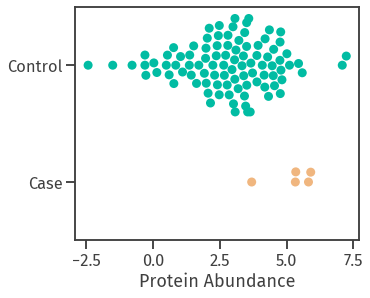

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.swarmplot(x=df["score_1"], y=df["disease"], size=9, ax=ax)
ax.set_xlabel("Protein Abundance")
ax.set_ylabel("")
save("swarm_imbalanced.png")

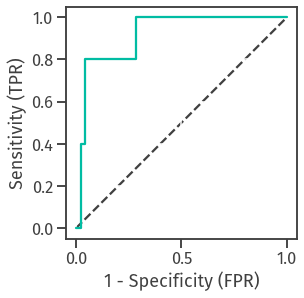

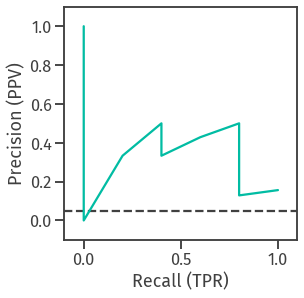

In [27]:
fig, ax = plt.subplots(figsize=half_size)
ax = roc_axis(ax)
ax.plot(fpr_1, tpr_1)
save("roc_imbalance.png")

fig, ax = plt.subplots(figsize=half_size)
ax = pr_axis((df["label"] == True).sum() / len(df), ax)
ax.plot(rec_1, prc_1)
save("pr_imbalance.png")